## Spectral grid fitting for the SALT spectra

We could do this with PHOENIX spectra, they go down to Teff=2600 K. 

The spectra are available here, on a one-by-one basis:

http://phoenix.astro.physik.uni-goettingen.de/?page_id=15

or for bulk download here:

ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/

We could also do this with BT-Settl

http://svo2.cab.inta-csic.es/theory/newov2/index.php?models=bt-settl

and the paper with details is here:

https://www.aanda.org/articles/aa/pdf/2013/05/aa19058-12.pdf

The spectra then need to be rotationally broadened. The broadening can be done with the eniric python package:

https://eniric.readthedocs.io/en/latest/

and the sampling to the instrument resolution of SALT's spectrograph can be done with a native astropy tool via "convolve":

https://docs.astropy.org/en/stable/convolution/


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.constants import R_sun

# Get spectra

In [4]:
dirr = "/home/ekaterina/Documents/001_science/MalachiteMountains/data"

sp2 = pd.read_csv(f"{dirr}/salt/R202002090014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
sp = pd.read_csv(f"{dirr}/btsettl/2800K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])

In [15]:
sp2.shape

(389483, 2)

(5000.0, 8600.0)

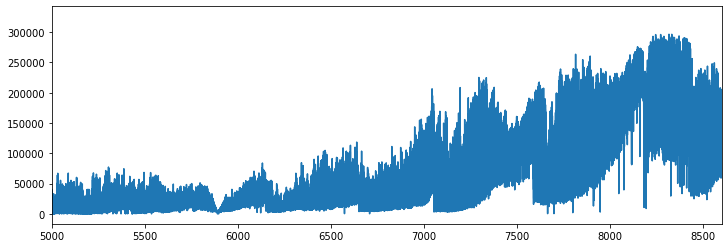

In [14]:
%matplotlib inline

plt.figure(figsize=(12,4))
plt.plot(sp2.lambd, sp2.flux)
plt.xlim(5000,8600)

#plt.ylim(-.003,.005)

(5000.0, 8600.0)

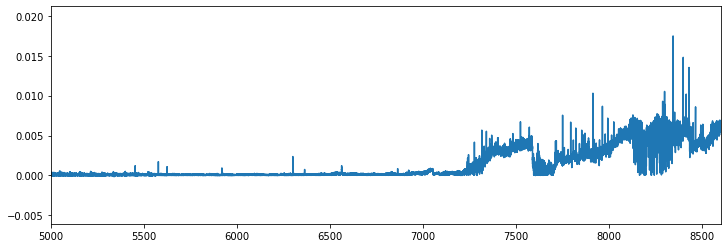

In [13]:
%matplotlib inline

plt.figure(figsize=(12,4))
plt.errorbar(sp.lambd, sp.flux, yerr=sp.flux_err)

plt.xlim(5000,8600)
#plt.ylim(-.003,.005)

In [21]:
hdu = fits.open(f"{dirr}/phoenix/lte02800-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")

In [24]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =              1569128                                                  
EXTEND  =                    T                                                  
EXTNAME = 'PRIMARY '                                                            
WAVE    = '../../WAVE_PHOENIX-ACES-AGSS-COND-2011.fits' / Wavelength array      
PHXTEFF =               2800.0 / [K] effective temperature                      
PHXLOGG =                  4.5 / [cm/s^2] log (surface gravity)                 
PHXM_H  =                  0.0 / [M/H] metallicity (rel. sol. - Asplund &a 2009)
PHXALPHA=                  0.0 / [a/M] alpha element enhancement                
PHXDUST =                    F / Dust in atmosphere                             
PHXEOS  = 'ACES    '        

In [126]:
hdu[1].data

FITS_rec([( 100, 'H', 12.  ), ( 200, 'He', 10.93), ( 300, 'Li',  3.26),
          ( 400, 'Be',  1.38), ( 500, 'B',  2.79), ( 600, 'C',  8.43),
          ( 700, 'N',  7.83), ( 800, 'O',  8.69), ( 900, 'F',  4.56),
          (1000, 'Ne',  7.93), (1100, 'Na',  6.24), (1200, 'Mg',  7.6 ),
          (1300, 'Al',  6.45), (1400, 'Si',  7.51), (1500, 'P',  5.41),
          (1600, 'S',  7.12), (1700, 'Cl',  5.5 ), (1800, 'Ar',  6.4 ),
          (1900, 'K',  5.08), (2000, 'Ca',  6.34), (2100, 'Sc',  3.15),
          (2200, 'Ti',  4.95), (2300, 'V',  3.93), (2400, 'Cr',  5.64),
          (2500, 'Mn',  5.43), (2600, 'Fe',  7.5 ), (2700, 'Co',  4.99),
          (2800, 'Ni',  6.22), (2900, 'Cu',  4.19), (3000, 'Zn',  4.56),
          (3100, 'Ga',  3.04), (3200, 'Ge',  3.65), (3300, 'As',  2.3 ),
          (3400, 'Se',  3.34), (3500, 'Br',  2.54), (3600, 'Kr',  3.25),
          (3700, 'Rb',  2.36), (3800, 'Sr',  2.87), (3900, 'Y',  2.21),
          (4000, 'Zr',  2.58), (4100, 'Nb',  1.46), (4200, 'Mo

In [30]:
rad = 0.142 * R_sun

rad.to("cm")

Hm. Why is effective radius != Sarah's radius or Mamajek"s radius (a little smaller than Sarah's)?

In [56]:
spectrum = hdu[0].data

In [57]:
grid = fits.open(f"{dirr}/phoenix/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits") # phoenix wavelength grid

In [58]:
grid[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =              1569128                                                  
EXTEND  =                    T                                                  
EXTNAME = 'PRIMARY '                                                            
UNIT    = 'Angstrom'                                                            
COMMENT Wavelength array for PHOENIX grid 'PHOENIX-ACES-AGSS-COND-2011'         

In [59]:
lambdas = grid[0].data # in angstroem

In [111]:
wav = lambdas[(lambdas>6560) & (lambdas<6570) ]
wav.shape

(999,)

# Rotational broadening

[see eniric docs](https://eniric.readthedocs.io/en/latest/broadening.html#rotational-broadening)

In [112]:
from eniric import broaden

In [115]:
specs = []
spec_min_BB = spectrum/np.mean(spectrum) - flux_BB.value/np.mean(flux_BB.value)
vsinis = [30,60,90,120]
for vsini in vsinis:
    specs.append(broaden.rotational_convolution(wav, lambdas, spec_min_BB, vsini))

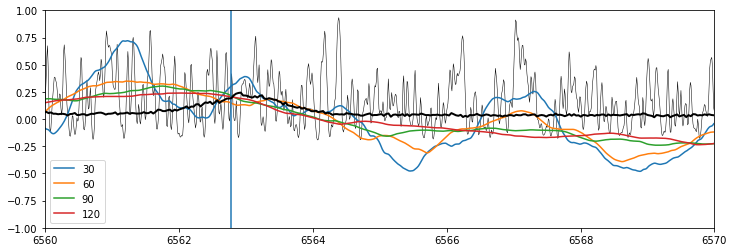

In [121]:
plt.figure(figsize=(12,4))
vsinis = [30,60,90,120]
plt.errorbar(sp.lambd, sp.flux*200, yerr=sp.flux_err, c="k", linewidth=2)
plt.plot(lambdas, spec_min_BB, c="k", linewidth=0.5)
for vsini, broad_spectrum in zip(vsinis, specs):
    plt.plot(wav, broad_spectrum/np.mean(broad_spectrum)-1, label=vsini)
plt.xlim(6560,6570)
plt.axvline(6562.78)
plt.ylim(-1,1)
plt.legend();

In [104]:
from astropy.modeling.models import BlackBody
from astropy import units as u
#from astropy.visualization import quantity_support

bb = BlackBody(temperature=2800*u.K)
wav_BB = lambdas * u.AA
flux_BB = bb(wav_BB)

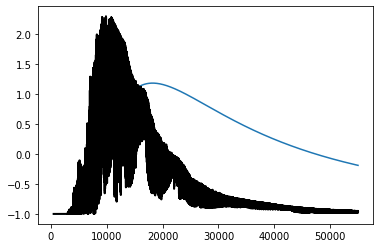

In [105]:
plt.plot(wav_BB.value, flux_BB.value/np.mean(flux_BB.value)-1)
plt.plot(lambdas, spectrum/np.mean(spectrum)-1, c="k", linewidth=2)

(6560.0, 6570.0)

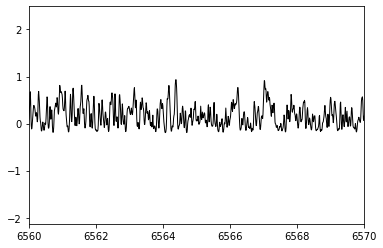

In [109]:
plt.plot(lambdas, spectrum/np.mean(spectrum) - flux_BB.value/np.mean(flux_BB.value), c="k", linewidth=1)
plt.xlim(4000,9000)
plt.xlim(6560,6570)

In [96]:
lambdas[-1]

54999.75